/var/folders/f2/gq8xgm9x491cqwtct_tgpy0h0000gn/T/ipykernel_98587/816676029.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['user_id','variable'], group_keys=False).apply(cap_iqr).reset_index(drop=True)
/var/folders/f2/gq8xgm9x491cqwtct_tgpy0h0000gn/T/ipykernel_98587/816676029.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  contiguous = daily.groupby('user_id',group_keys=False).app

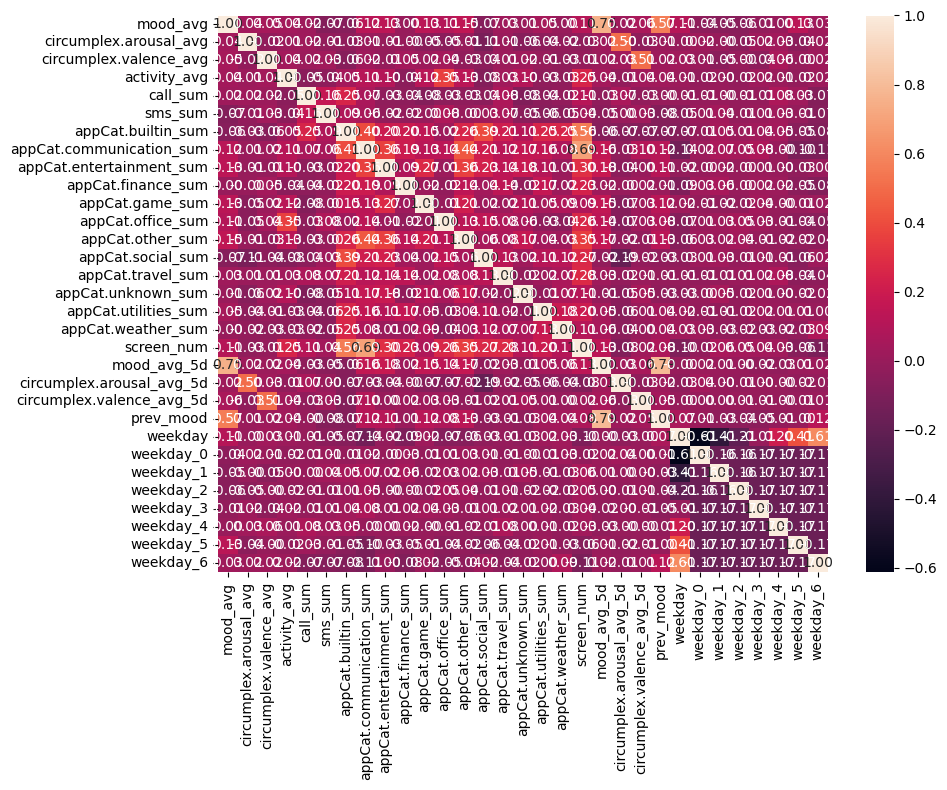

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import QuantileTransformer

df = pd.read_csv('dataset_mood_smartphone.csv').rename(columns={'id':'user_id','time':'timestamp'})
valid_intervals = {
    'mood': range(1,11),
    'circumplex.arousal': range(-2,3),
    'circumplex.valence': range(-2,3),
    'activity': [0,1],
    'call': {0,1},
    'sms': {0,1}
}
mask_valid = df.apply(lambda r: (r['variable'] not in valid_intervals) or (r['value'] in valid_intervals[r['variable']]), axis=1)
df = df.loc[mask_valid].drop_duplicates(subset=['user_id','timestamp','variable']).copy()

def cap_iqr(g):
    q1,q3 = g['value'].quantile([0.25,0.75])
    iqr = q3 - q1
    return g.assign(value=g['value'].clip(q1-1.5*iqr, q3+1.5*iqr))
df = df.groupby(['user_id','variable'], group_keys=False).apply(cap_iqr).reset_index(drop=True)

df['timestamp']     = pd.to_datetime(df['timestamp'])
df['date']          = df['timestamp'].dt.date
df['hour']          = df['timestamp'].dt.hour
df['weekday']       = df['timestamp'].dt.weekday
df['week_of_year']  = df['timestamp'].dt.isocalendar().week
df['month']         = df['timestamp'].dt.month
df['part_of_day']   = pd.cut(df['hour'], bins=[0,6,12,18,24],
                             labels=['Night','Morning','Afternoon','Evening'], right=False)
df['is_weekend']    = df['weekday'].isin([5,6]).astype(int)

for dim in ['circumplex.arousal','circumplex.valence']:
    mask = df['variable']==dim
    vals = df.loc[mask].sort_values('timestamp')['value']
    df.loc[mask,'value'] = vals.interpolate(method='nearest').values

df = df[~(df['variable'].str.startswith('appCat') & (df['value']<0))].copy()

daily = pd.DataFrame()
agg_defs = {'mood':'mean','circumplex.arousal':'mean','circumplex.valence':'mean','activity':'mean'}
others  = {v:'sum' for v in df['variable'].unique() if v not in agg_defs and v!='screen'}
full_defs = {**agg_defs, **others, **{'screen':'count'}}
for var,func in full_defs.items():
    grp = df[df['variable']==var].groupby(['user_id','date'])['value']
    name = f"{var}_{'avg' if func=='mean' else 'num' if func=='count' else 'sum'}"
    res = getattr(grp,func)().reset_index(name=name)
    daily = res if daily.empty else daily.merge(res,on=['user_id','date'],how='outer')
fill_zero = {c:0 for c in daily.columns if c.endswith(('_sum','_num'))}
daily = daily.fillna(fill_zero).sort_values(['user_id','date'])

def longest_block(g):
    g = g.copy()
    g['has_mood'] = ~g['mood_avg'].isna()
    g['gap']      = g['date'].diff().dt.days.fillna(0)
    g['block']    = (g['gap']>1).cumsum()
    sizes = g[g['has_mood']].groupby('block').size()
    idx   = sizes.idxmax()
    dates = g[(g['block']==idx)&g['has_mood']]['date']
    return g[g['date'].between(dates.min(),dates.max())]

contiguous = daily.groupby('user_id',group_keys=False).apply(longest_block).reset_index(drop=True)

for col in ['mood_avg','circumplex.arousal_avg','circumplex.valence_avg']:
    contiguous[col] = contiguous.groupby('user_id')[col].transform(lambda s: s.interpolate(method='nearest'))
contiguous['screen_num'] = contiguous['screen_num'].fillna(0)

for col in ['mood_avg','circumplex.arousal_avg','circumplex.valence_avg']:
    contiguous[f"{col}_5d"] = contiguous.groupby('user_id')[col].transform(lambda s: s.rolling(5,min_periods=1).mean())
contiguous['prev_mood'] = contiguous.groupby('user_id')['mood_avg'].shift(1)

# ensure 'weekday' exists here based on the 'date' column
contiguous['weekday'] = pd.to_datetime(contiguous['date']).dt.weekday
weekday_dummies = pd.get_dummies(contiguous['weekday'], prefix='weekday')
contiguous = pd.concat([contiguous, weekday_dummies], axis=1)

contiguous['target_mood'] = contiguous.groupby('user_id')['mood_avg'].shift(-1)
final_df = contiguous.drop(columns=['has_mood','gap','block']).dropna()

final_df.to_csv('final_dataset.csv', index=False)
corr = final_df.drop(columns=['user_id','date','target_mood']).corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.tight_layout()
plt.show()

qt = QuantileTransformer(output_distribution='normal', random_state=0)
num_cols = [c for c in final_df.columns if c.endswith(('_avg','_sum','_num'))]
normalized_df = final_df.copy()
normalized_df[num_cols] = qt.fit_transform(normalized_df[num_cols])
normalized_df.to_csv('normalized_dataset.csv', index=False)


In [2]:
# df.columns()

In [3]:
# Identify all the weekday‐dummy columns and drop them
weekday_dummies = [col for col in final_df.columns if col.startswith('weekday')]
pruned_df = final_df.drop(columns=weekday_dummies, errors='ignore')

# Write out the cleaned dataset
pruned_df.to_csv("mood_dataset.csv", index=False)


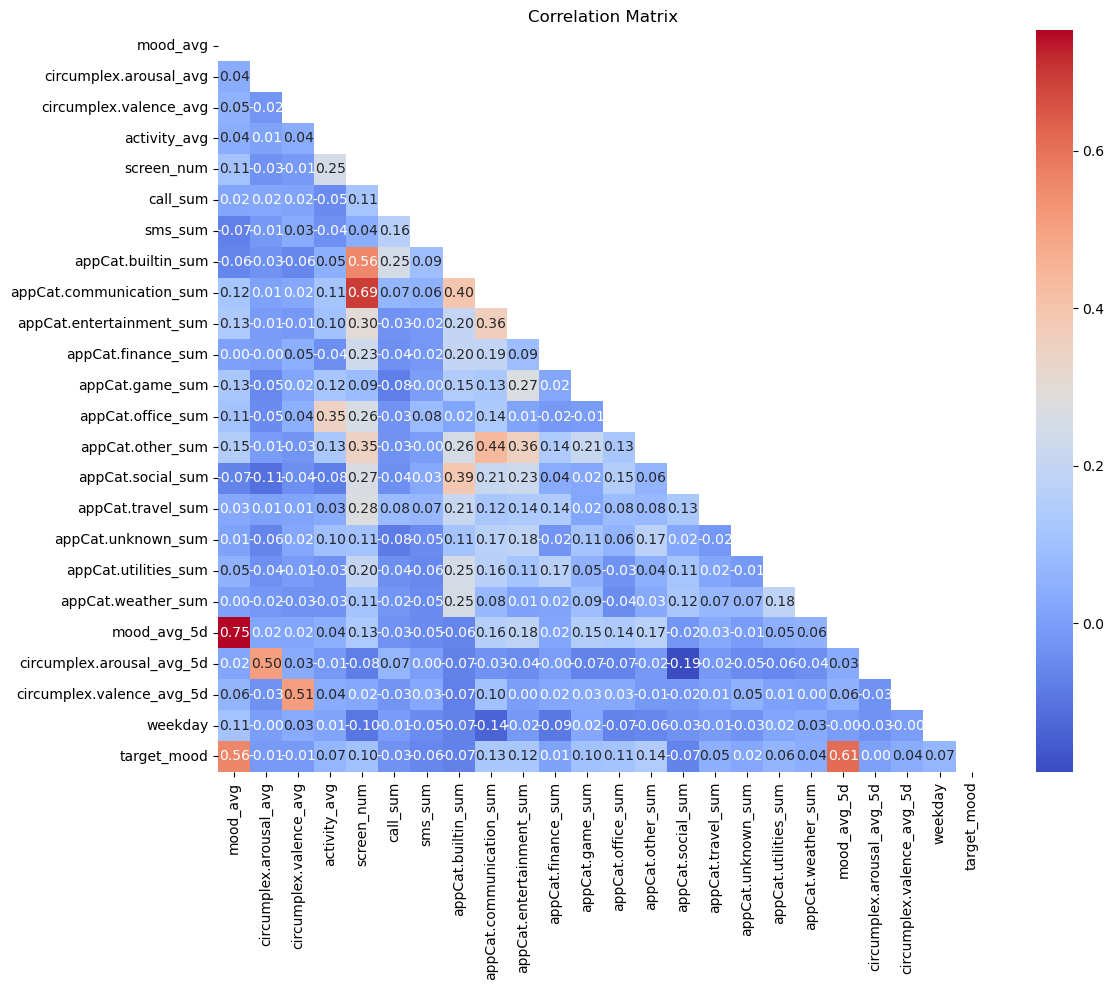

10 columns with the smallest correlation to 'target_mood':
appCat.builtin_sum          -0.068017
appCat.social_sum           -0.066105
sms_sum                     -0.056815
call_sum                    -0.031288
circumplex.arousal_avg      -0.009384
circumplex.valence_avg      -0.008858
circumplex.arousal_avg_5d    0.003651
appCat.finance_sum           0.009942
appCat.unknown_sum           0.024228
circumplex.valence_avg_5d    0.038217
Name: target_mood, dtype: float64

10 columns with the largest correlation to 'target_mood':
target_mood                 1.000000
mood_avg_5d                 0.611765
mood_avg                    0.561151
appCat.other_sum            0.144142
appCat.communication_sum    0.128475
appCat.entertainment_sum    0.122108
appCat.office_sum           0.111224
appCat.game_sum             0.103972
screen_num                  0.102304
weekday                     0.068472
Name: target_mood, dtype: float64


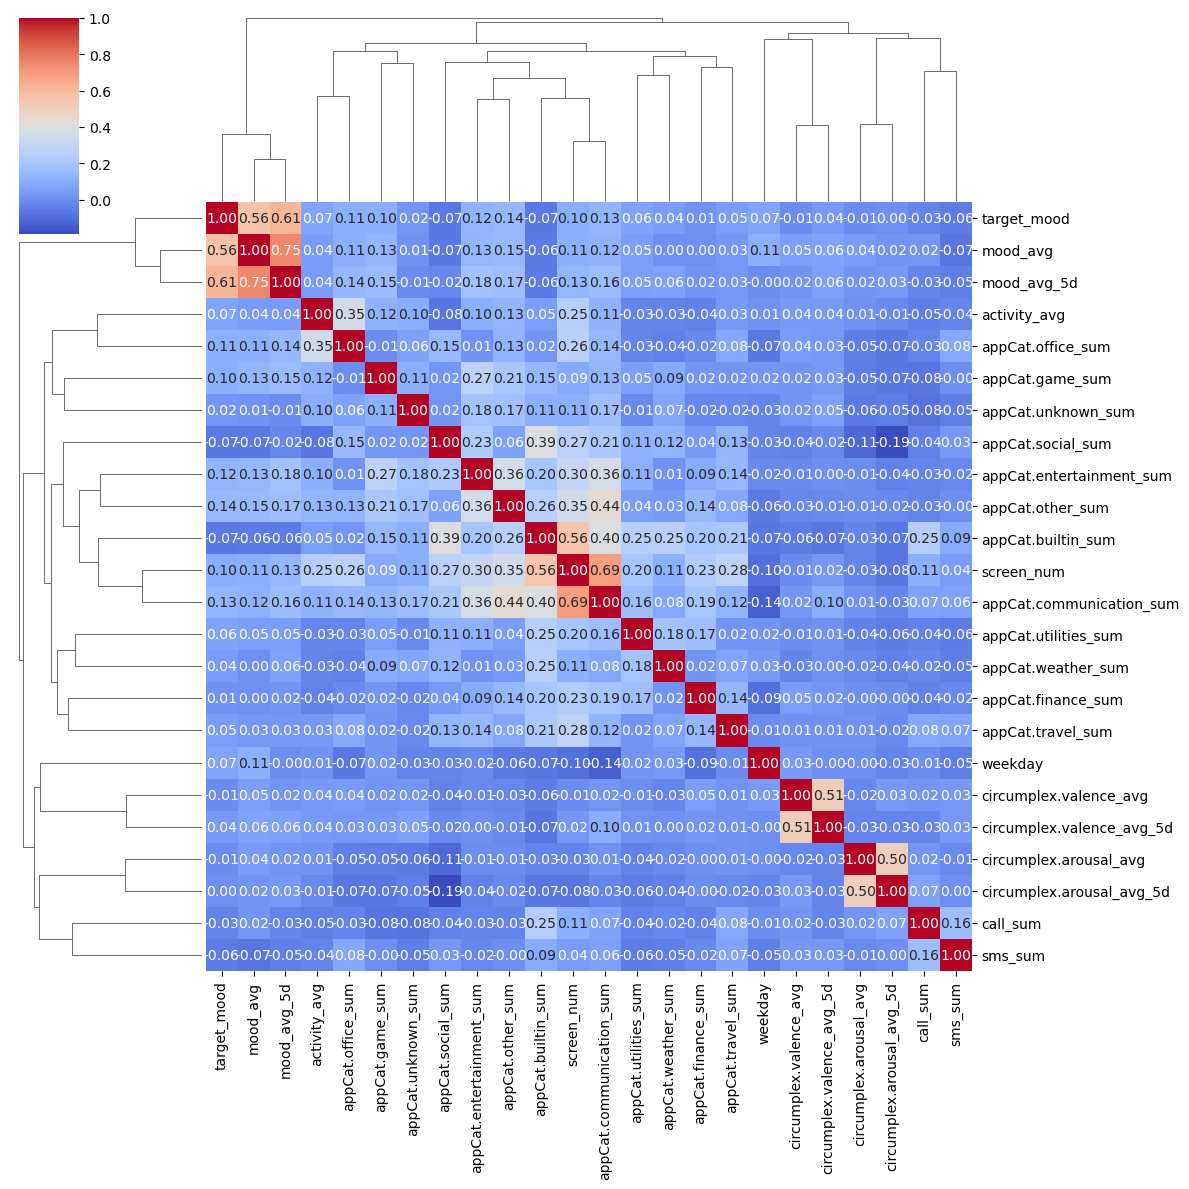

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

selected_columns = [
    'mood_avg', 'circumplex.arousal_avg', 'circumplex.valence_avg',
    'activity_avg', 'screen_num', 'call_sum', 'sms_sum',
    'appCat.builtin_sum', 'appCat.communication_sum',
    'appCat.entertainment_sum', 'appCat.finance_sum', 'appCat.game_sum',
    'appCat.office_sum', 'appCat.other_sum', 'appCat.social_sum',
    'appCat.travel_sum', 'appCat.unknown_sum', 'appCat.utilities_sum',
    'appCat.weather_sum', 'mood_avg_5d',
    'circumplex.arousal_avg_5d', 'circumplex.valence_avg_5d',
    'weekday', 'target_mood'
]

corr_subset = final_df[selected_columns]
correlation_matrix = corr_subset.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', ax=ax)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

correlation_matrix.to_csv('correlation_matrix.csv')

min_corr = correlation_matrix['target_mood'].sort_values().head(10)
max_corr = correlation_matrix['target_mood'].sort_values(ascending=False).head(10)
print("10 columns with the smallest correlation to 'target_mood':")
print(min_corr)
print("\n10 columns with the largest correlation to 'target_mood':")
print(max_corr)

sns.clustermap(correlation_matrix, cmap='coolwarm', figsize=(12, 12), annot=True, fmt=".2f")
plt.show()


The columns with the 10 smallest correlations to 'target_mood':
appCat.builtin_sum          -0.068017
appCat.social_sum           -0.066105
sms_sum                     -0.056815
call_sum                    -0.031288
circumplex.arousal_avg      -0.009384
circumplex.valence_avg      -0.008858
circumplex.arousal_avg_5d    0.003651
appCat.finance_sum           0.009942
appCat.unknown_sum           0.024228
circumplex.valence_avg_5d    0.038217
Name: target_mood, dtype: float64
The columns with the 10 largest correlations to 'target_mood':
target_mood                 1.000000
mood_avg_5d                 0.611765
mood_avg                    0.561151
appCat.other_sum            0.144142
appCat.communication_sum    0.128475
appCat.entertainment_sum    0.122108
appCat.office_sum           0.111224
appCat.game_sum             0.103972
screen_num                  0.102304
weekday                     0.068472
Name: target_mood, dtype: float64


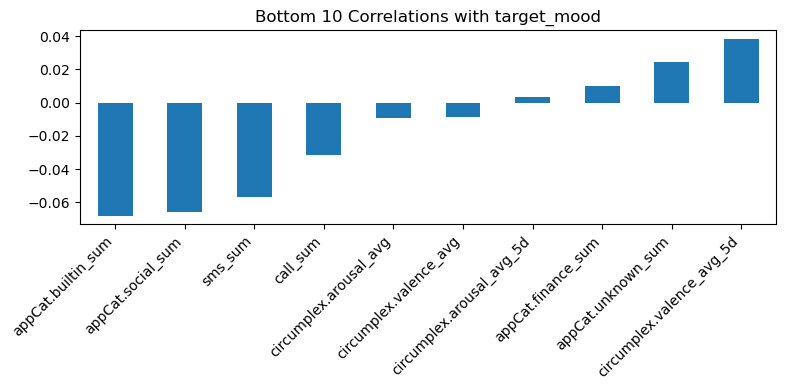

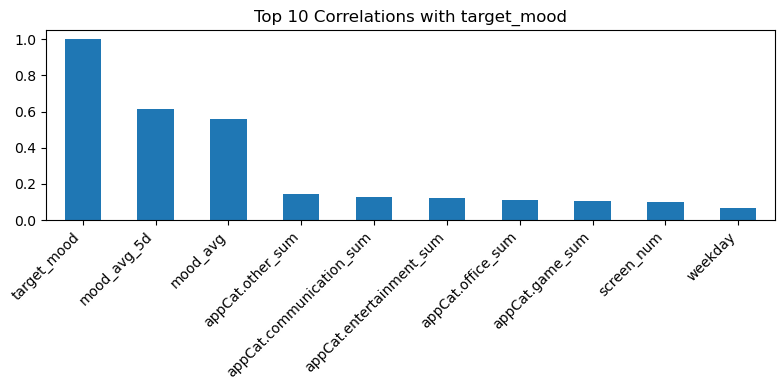

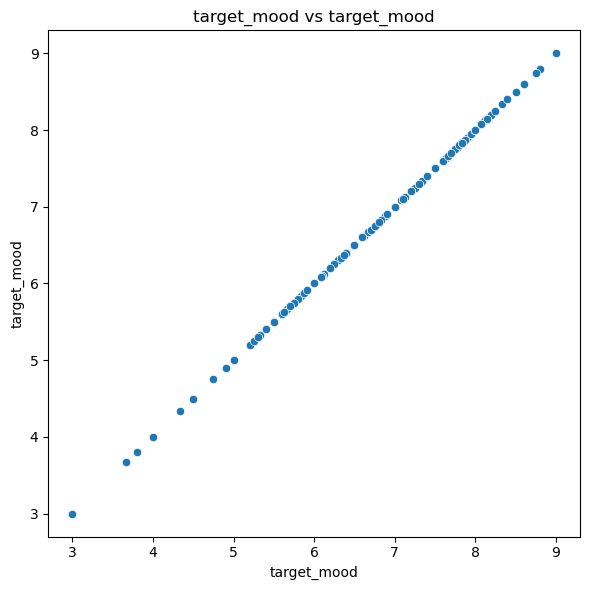

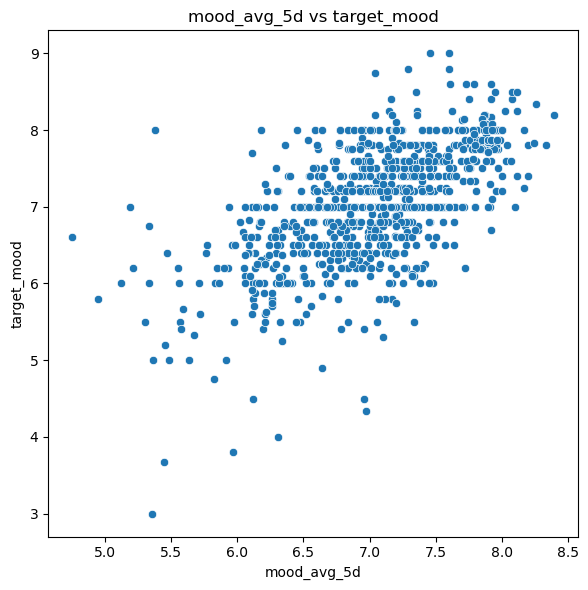

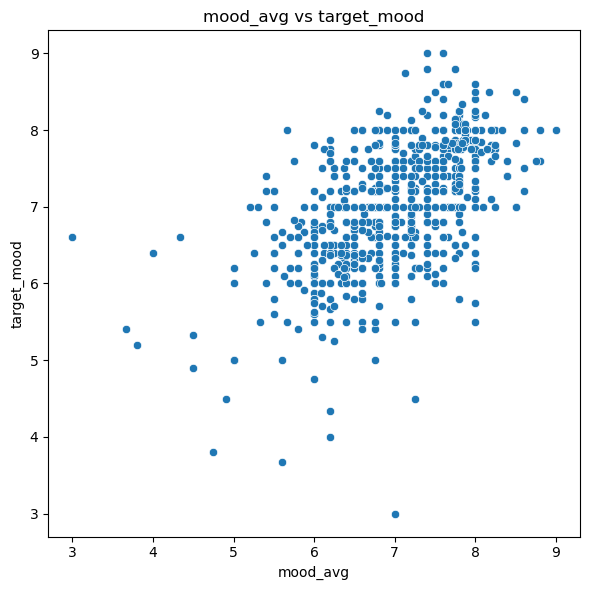

In [5]:
min_corr_columns = (
    correlation_matrix['target_mood']
    .sort_values(ascending=True)
    .head(10)
)
print("The columns with the 10 smallest correlations to 'target_mood':")
print(min_corr_columns)

max_corr_columns = (
    correlation_matrix['target_mood']
    .sort_values(ascending=False)
    .head(10)
)
print("The columns with the 10 largest correlations to 'target_mood':")
print(max_corr_columns)

import pandas as pd
pd.concat([min_corr_columns, max_corr_columns], axis=1, keys=['min_corr','max_corr']).to_csv('target_mood_corr_extremes.csv')

import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
min_corr_columns.plot(kind='bar')
plt.title("Bottom 10 Correlations with target_mood")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.figure(figsize=(8,4))
max_corr_columns.plot(kind='bar')
plt.title("Top 10 Correlations with target_mood")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

import seaborn as sns
for feat in max_corr_columns.index[:3]:
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=corr_subset[feat], y=corr_subset['target_mood'])
    plt.title(f"{feat} vs target_mood")
    plt.tight_layout()
    plt.show()


   user_id        date  mood_avg  circumplex.arousal_avg  \
1  AS14.01  2014-03-22      6.50                    0.00   
2  AS14.01  2014-03-23      6.80                   -0.20   
3  AS14.01  2014-03-24      6.10                    0.40   
4  AS14.01  2014-03-25      6.75                    0.75   
5  AS14.01  2014-03-26      6.60                    0.40   

   circumplex.valence_avg  activity_avg  call_sum  sms_sum  \
1                     1.0           0.0       3.0      1.0   
2                     1.0           0.0       0.0      0.0   
3                     1.0           0.0      10.0      0.0   
4                     1.0           0.0       0.0      1.0   
5                     1.0           0.0       0.0      0.0   

   appCat.communication_sum  appCat.finance_sum  ...  prev_mood  weekday  \
1                  3706.446              21.076  ...       6.20        5   
2                  3978.370              43.403  ...       6.50        6   
3                  6705.831           

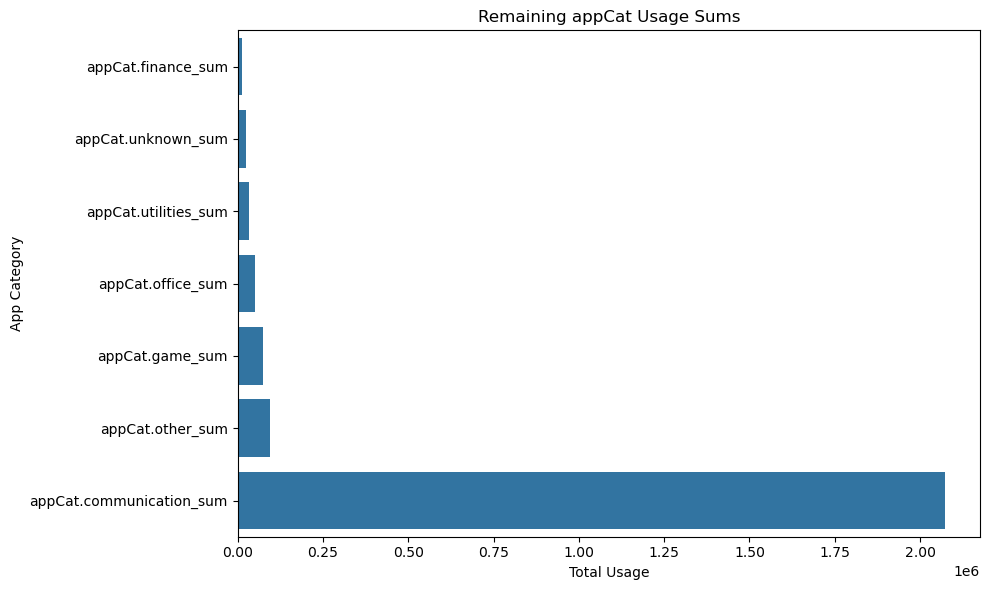

In [6]:
full_df = final_df.copy()
cols_to_drop = [
    'appCat.social_sum', 'appCat.builtin_sum', 
    'appCat.entertainment_sum', 'appCat.weather_sum', 
    'appCat.travel_sum'
]
pruned_df = full_df.drop(columns=cols_to_drop, errors='ignore')
print(pruned_df.head())

dropped_cols = [c for c in cols_to_drop if c in full_df.columns]
missing_cols = [c for c in cols_to_drop if c not in full_df.columns]
print("Dropped columns:", dropped_cols)
print("Columns not found:", missing_cols)
print("Shape before drop:", full_df.shape, "Shape after drop:", pruned_df.shape)

pruned_df.to_csv('pruned_dataset.csv', index=False)

remaining_appcat = [c for c in pruned_df.columns if c.startswith('appCat')]
if remaining_appcat:
    import matplotlib.pyplot as plt
    import seaborn as sns
    sums = pruned_df[remaining_appcat].sum().sort_values()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=sums.values, y=sums.index)
    plt.xlabel("Total Usage")
    plt.ylabel("App Category")
    plt.title("Remaining appCat Usage Sums")
    plt.tight_layout()
    plt.show()


   mood_avg  circumplex.arousal_avg  call_sum  sms_sum  appCat.builtin_sum  \
1      6.50                    0.00       3.0      1.0           487.45175   
2      6.80                   -0.20       0.0      0.0           596.23175   
3      6.10                    0.40      10.0      0.0           782.17325   
4      6.75                    0.75       0.0      1.0           542.68775   
5      6.60                    0.40       0.0      0.0           747.60650   

   appCat.communication_sum  appCat.entertainment_sum  appCat.finance_sum  \
1                  3706.446                    93.324              21.076   
2                  3978.370                    94.346              43.403   
3                  6705.831                   540.009              34.106   
4                  6600.763                    68.206              43.054   
5                  6637.607                   897.385              52.331   

   appCat.game_sum  appCat.office_sum  ...  prev_mood  weekday  week

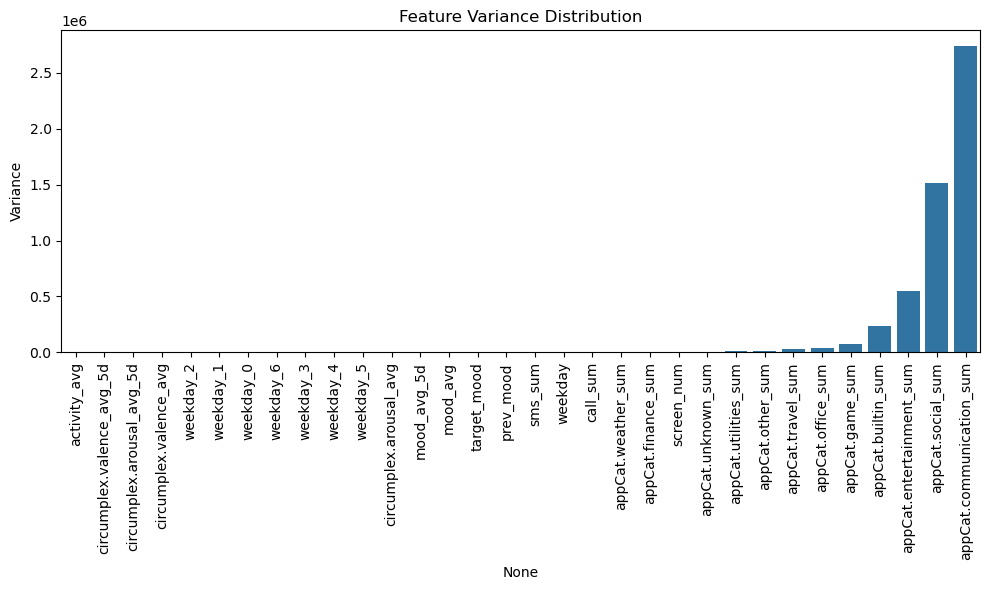

In [7]:
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
import seaborn as sns

feat_df = final_df.drop(columns=['user_id','date'], errors='ignore')
vt = VarianceThreshold(threshold=0.1)
filtered_array = vt.fit_transform(feat_df)
mask = vt.get_support(indices=True)
kept_cols = feat_df.columns[mask]
filtered_features = pd.DataFrame(filtered_array, columns=kept_cols, index=feat_df.index)
print(filtered_features.head())

removed_cols = [c for c in feat_df.columns if c not in kept_cols]
print('Kept columns:', list(kept_cols))
print('Removed columns:', removed_cols)

variances = feat_df.var().sort_values()
plt.figure(figsize=(10,6))
sns.barplot(x=variances.index, y=variances.values)
plt.xticks(rotation=90)
plt.ylabel('Variance')
plt.title('Feature Variance Distribution')
plt.tight_layout()
plt.show()

filtered_features.to_csv('filtered_features.csv', index=False)


In [8]:
filtered_features

,mood_avg,circumplex.arousal_avg,call_sum,sms_sum,appCat.builtin_sum,appCat.communication_sum,appCat.entertainment_sum,appCat.finance_sum,appCat.game_sum,appCat.office_sum,...,prev_mood,weekday,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,target_mood
1,6.50,0.000000,3.0,1.0,487.45175,3706.4460,93.3240,21.076,0.0,0.000,...,6.20,5.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6.80
2,6.80,-0.200000,0.0,0.0,596.23175,3978.3700,94.3460,43.403,0.0,0.000,...,6.50,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.10
3,6.10,0.400000,10.0,0.0,782.17325,6705.8310,540.0090,34.106,0.0,3.010,...,6.80,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.75
4,6.75,0.750000,0.0,1.0,542.68775,6600.7630,68.2060,43.054,0.0,0.000,...,6.10,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6.60
5,6.60,0.400000,0.0,0.0,747.60650,6637.6070,897.3850,52.331,0.0,0.000,...,6.75,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1280,5.70,0.200000,10.0,3.0,785.95950,1011.7780,683.4835,0.000,0.0,130.530,...,6.25,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.20
1281,6.20,0.400000,1.0,2.0,367.36250,1542.0475,124.6940,0.000,0.0,0.000,...,5.70,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7.70
1282,7.70,0.200000,10.0,1.0,1595.74700,1826.9150,614.7060,0.000,0.0,305.859,...,6.20,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.00
1283,7.00,0.666667,5.0,1.0,344.27050,328.7155,136.7380,0.000,0.0,0.000,...,7.70,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6.80


## Task2A APPLICATION OF CLASSIFICATION ALGORITHMS

### Random Forest

In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# 1) separate predictors from the target
X_df = filtered_features.drop(columns=['target_mood'])
y = filtered_features['target_mood'].round().astype(int)

# 2) standardize the features
std_scaler = StandardScaler()
X_scaled = std_scaler.fit_transform(X_df)

# 3) split into train/test sets
X_tr, X_val, y_tr, y_val = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

# 4) set up hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8]
}

# 5) base classifier and grid search
rf_base = RandomForestClassifier(random_state=42)
gs = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)
gs.fit(X_tr, y_tr)

# 6) retrain with best parameters
print("Best hyperparameters found:", gs.best_params_)
rf_best = RandomForestClassifier(**gs.best_params_, random_state=42)
rf_best.fit(X_tr, y_tr)

# 7) evaluate on the validation set
y_hat = rf_best.predict(X_val)
print("Random Forest classification report:")
print(classification_report(y_val, y_hat, zero_division=1))


Best hyperparameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Random Forest classification report:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           5       1.00      0.00      0.00         6
           6       0.56      0.48      0.51        61
           7       0.69      0.81      0.74       181
           8       0.63      0.49      0.55        75
           9       1.00      0.00      0.00         1

    accuracy                           0.66       325
   macro avg       0.81      0.30      0.30       325
weighted avg       0.66      0.66      0.64       325



### LSTM

In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report

# --- Data Preparation -------------------------------------------------------

# start from your filtered_features DataFrame
df = filtered_features.copy()

# round and drop NaNs
df['target_mood'] = df['target_mood'].round().astype(int)
df.dropna(subset=['target_mood'], inplace=True)

# encode to contiguous integer labels 0..(n_classes-1)
le = LabelEncoder()
y_orig = df['target_mood'].values
y = le.fit_transform(y_orig)
num_classes = len(le.classes_)

# extract features
X = df.drop(columns=['target_mood']).values

# scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# train/test split
X_tr, X_te, y_tr, y_te = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# tensorize (add seq dim=1 for LSTM)
X_tr_t = torch.tensor(X_tr, dtype=torch.float32).unsqueeze(1)
y_tr_t = torch.tensor(y_tr, dtype=torch.long)
X_te_t = torch.tensor(X_te, dtype=torch.float32).unsqueeze(1)
y_te_t = torch.tensor(y_te, dtype=torch.long)

train_ds = TensorDataset(X_tr_t, y_tr_t)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)


# --- Model Definition -------------------------------------------------------

class SequenceMoodPredictor(nn.Module):
    def __init__(self, in_features, hidden_size, n_layers, out_classes):
        super().__init__()
        self.lstm = nn.LSTM(in_features, hidden_size, n_layers, batch_first=True)
        self.head = nn.Linear(hidden_size, out_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.head(out[:, -1, :])


# --- Hyperparameter Search -------------------------------------------------

def objective(trial):
    hidden_size = trial.suggest_int("hidden_size", 50, 100)
    n_layers    = trial.suggest_int("n_layers", 1, 3)
    lr          = trial.suggest_float("lr", 1e-5, 1e-2, log=True)

    model     = SequenceMoodPredictor(
                    in_features=X_tr_t.shape[2],
                    hidden_size=hidden_size,
                    n_layers=n_layers,
                    out_classes=num_classes
                )
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn   = nn.CrossEntropyLoss()

    model.train()
    for _ in range(10):
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss  = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        preds = model(X_te_t)
        acc   = (preds.argmax(dim=1) == y_te_t).float().mean().item()
    return acc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
print("Best hyperparameters:", study.best_params)


# --- Final Training & Evaluation -------------------------------------------

model     = SequenceMoodPredictor(
                in_features=X_tr_t.shape[2],
                hidden_size=study.best_params["hidden_size"],
                n_layers=study.best_params["n_layers"],
                out_classes=num_classes
            )
optimizer = optim.Adam(model.parameters(), lr=study.best_params["lr"])
loss_fn   = nn.CrossEntropyLoss()

for epoch in range(1, 31):
    model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss  = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch:2}/30 – Loss: {loss.item():.4f}")

model.eval()
with torch.no_grad():
    preds  = model(X_te_t)
    y_pred = preds.argmax(dim=1).cpu()
    y_true = y_te_t.cpu()

print(classification_report(y_true, y_pred, zero_division=0))


/Users/antonis/miniforge3/envs/python3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-04-19 12:38:32,363] A new study created in memory with name: no-name-5bc1afa1-20e3-48de-a3ad-a518fea56515
[I 2025-04-19 12:38:33,250] Trial 0 finished with value: 0.5852534770965576 and parameters: {'hidden_size': 58, 'n_layers': 1, 'lr': 0.0002955454493534199}. Best is trial 0 with value: 0.5852534770965576.
[I 2025-04-19 12:38:33,438] Trial 1 finished with value: 0.23963133990764618 and parameters: {'hidden_size': 51, 'n_layers': 1, 'lr': 1.3824402515870949e-05}. Best is trial 0 with value: 0.5852534770965576.
[I 2025-04-19 12:38:33,622] Trial 2 finished with value: 0.5437787771224976 and parameters: {'hidden_size': 54, 'n_layers': 1, 'lr': 1.767651145649547e-05}. Best is trial 0 with value: 0.58525347709

Best hyperparameters: {'hidden_size': 72, 'n_layers': 3, 'lr': 0.001525795841051871}
Epoch  1/30 – Loss: 1.8628
Epoch  2/30 – Loss: 1.6327
Epoch  3/30 – Loss: 1.2216
Epoch  4/30 – Loss: 0.9726
Epoch  5/30 – Loss: 0.7772
Epoch  6/30 – Loss: 0.6814
Epoch  7/30 – Loss: 0.7838
Epoch  8/30 – Loss: 0.7802
Epoch  9/30 – Loss: 0.6779
Epoch 10/30 – Loss: 0.8031
Epoch 11/30 – Loss: 0.6488
Epoch 12/30 – Loss: 0.9828
Epoch 13/30 – Loss: 0.7887
Epoch 14/30 – Loss: 0.5833
Epoch 15/30 – Loss: 0.8528
Epoch 16/30 – Loss: 0.7804
Epoch 17/30 – Loss: 1.0474
Epoch 18/30 – Loss: 1.2338
Epoch 19/30 – Loss: 1.0261
Epoch 20/30 – Loss: 0.8227
Epoch 21/30 – Loss: 0.6007
Epoch 22/30 – Loss: 0.7538
Epoch 23/30 – Loss: 0.6205
Epoch 24/30 – Loss: 0.7790
Epoch 25/30 – Loss: 0.5803
Epoch 26/30 – Loss: 0.5008
Epoch 27/30 – Loss: 0.8064
Epoch 28/30 – Loss: 0.5520
Epoch 29/30 – Loss: 0.6703
Epoch 30/30 – Loss: 0.5945
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       

### Transformer

In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report

# --- Data Preparation -------------------------------------------------------

# start from your filtered_features DataFrame
data_df = filtered_features.copy()

# round, drop NaNs, and shift labels to 0-based
data_df['target_mood'] = data_df['target_mood'].round().astype(int)
data_df.dropna(subset=['target_mood'], inplace=True)
labels = data_df['target_mood'].values - 1
num_classes = int(labels.max() + 1)

# extract feature matrix
features = data_df.drop(columns=['target_mood']).values

# scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, labels, test_size=0.2, random_state=42
)

# convert to torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # add seq dim=1
X_test_t  = torch.tensor(X_test,  dtype=torch.float32).unsqueeze(1)
y_train_t = torch.tensor(y_train, dtype=torch.long)
y_test_t  = torch.tensor(y_test,  dtype=torch.long)

# create DataLoader
train_ds = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)


# --- Model Definition -------------------------------------------------------

class MoodTransformer(nn.Module):
    def __init__(self, in_dim, hidden_dim, heads, layers, out_dim):
        super().__init__()
        self.embed = nn.Linear(in_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=heads,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=layers)
        self.classifier = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        # x: [batch, seq_len=1, in_dim]
        x = self.embed(x)            # [batch, 1, hidden_dim]
        x = self.encoder(x)          # [batch, 1, hidden_dim]
        return self.classifier(x[:, -1, :])  # use the final token


# --- Training Loop ----------------------------------------------------------

# hyperparameters
input_dim  = X_train_t.shape[2]
hidden_dim = 64
num_heads  = 4
num_layers = 2
output_dim = num_classes
lr         = 1e-3
epochs     = 60

model     = MoodTransformer(input_dim, hidden_dim, num_heads, num_layers, output_dim)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, epochs+1):
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss  = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch}/{epochs} — Loss: {avg_loss:.4f}")

# --- Evaluation -------------------------------------------------------------

model.eval()
with torch.no_grad():
    preds = model(X_test_t)
    y_pred = preds.argmax(dim=1).cpu()
    y_true = y_test_t.cpu()
    print("\nClassification Report (Transformer):")
    print(classification_report(y_true, y_pred, zero_division=0))


Epoch 1/60 — Loss: 1.1987
Epoch 2/60 — Loss: 0.9684
Epoch 3/60 — Loss: 0.8892
Epoch 4/60 — Loss: 0.8843
Epoch 5/60 — Loss: 0.8532
Epoch 6/60 — Loss: 0.8324
Epoch 7/60 — Loss: 0.7957
Epoch 8/60 — Loss: 0.7450
Epoch 9/60 — Loss: 0.7399
Epoch 10/60 — Loss: 0.7020
Epoch 11/60 — Loss: 0.6737
Epoch 12/60 — Loss: 0.6787
Epoch 13/60 — Loss: 0.6867
Epoch 14/60 — Loss: 0.6057
Epoch 15/60 — Loss: 0.5680
Epoch 16/60 — Loss: 0.5535
Epoch 17/60 — Loss: 0.5346
Epoch 18/60 — Loss: 0.5103
Epoch 19/60 — Loss: 0.4680
Epoch 20/60 — Loss: 0.4627
Epoch 21/60 — Loss: 0.4448
Epoch 22/60 — Loss: 0.4207
Epoch 23/60 — Loss: 0.3753
Epoch 24/60 — Loss: 0.3913
Epoch 25/60 — Loss: 0.4168
Epoch 26/60 — Loss: 0.3826
Epoch 27/60 — Loss: 0.3598
Epoch 28/60 — Loss: 0.2825
Epoch 29/60 — Loss: 0.2994
Epoch 30/60 — Loss: 0.2794
Epoch 31/60 — Loss: 0.2721
Epoch 32/60 — Loss: 0.2746
Epoch 33/60 — Loss: 0.2532
Epoch 34/60 — Loss: 0.2423
Epoch 35/60 — Loss: 0.2315
Epoch 36/60 — Loss: 0.2375
Epoch 37/60 — Loss: 0.2146
Epoch 38/6

## GRU with attention

In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report

# --- Data Preparation -------------------------------------------------------

# start from your filtered_features DataFrame
df = filtered_features.copy()

# round and drop missing targets
df['target_mood'] = df['target_mood'].round().astype(int)
df.dropna(subset=['target_mood'], inplace=True)

# encode labels to 0..C-1
le = LabelEncoder()
y = le.fit_transform(df['target_mood'].values)
num_classes = len(le.classes_)

# feature matrix
X = df.drop(columns=['target_mood']).values

# scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# tensorize and add sequence dimension
X_train_t = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # [batch, 1, feat]
X_test_t  = torch.tensor(X_test,  dtype=torch.float32).unsqueeze(1)
y_train_t = torch.tensor(y_train, dtype=torch.long)
y_test_t  = torch.tensor(y_test,  dtype=torch.long)

train_ds = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)


# --- Model Definition -------------------------------------------------------

class GRUAttentionClassifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_layers, out_dim):
        super().__init__()
        self.gru = nn.GRU(in_dim, hidden_dim, n_layers, batch_first=True)
        self.attn = nn.Linear(hidden_dim, 1)
        self.fc   = nn.Linear(hidden_dim, out_dim)
        
    def forward(self, x):
        # x: [batch, seq_len, in_dim]
        gru_out, _ = self.gru(x)                    # [batch, seq_len, hidden_dim]
        scores     = self.attn(gru_out)             # [batch, seq_len, 1]
        weights    = torch.softmax(scores, dim=1)   # [batch, seq_len, 1]
        context    = (weights * gru_out).sum(dim=1) # [batch, hidden_dim]
        return self.fc(context)                     # [batch, out_dim]


# --- Training Loop ----------------------------------------------------------

input_dim  = X_train_t.shape[2]
hidden_dim = 64
num_layers = 2
output_dim = num_classes
lr         = 1e-3
epochs     = 30

model     = GRUAttentionClassifier(input_dim, hidden_dim, num_layers, output_dim)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, epochs+1):
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss  = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch}/{epochs} — Loss: {avg_loss:.4f}")

# --- Evaluation -------------------------------------------------------------

model.eval()
with torch.no_grad():
    preds  = model(X_test_t)
    y_pred = preds.argmax(dim=1).cpu()
    y_true = y_test_t.cpu()
    print("\nClassification Report (GRU + Attention):")
    print(classification_report(y_true, y_pred, zero_division=0))


Epoch 1/30 — Loss: 1.9158
Epoch 2/30 — Loss: 1.7907
Epoch 3/30 — Loss: 1.6122
Epoch 4/30 — Loss: 1.3525
Epoch 5/30 — Loss: 1.0933
Epoch 6/30 — Loss: 0.9459
Epoch 7/30 — Loss: 0.9024
Epoch 8/30 — Loss: 0.8635
Epoch 9/30 — Loss: 0.8517
Epoch 10/30 — Loss: 0.8401
Epoch 11/30 — Loss: 0.8346
Epoch 12/30 — Loss: 0.8213
Epoch 13/30 — Loss: 0.8180
Epoch 14/30 — Loss: 0.8005
Epoch 15/30 — Loss: 0.7956
Epoch 16/30 — Loss: 0.8028
Epoch 17/30 — Loss: 0.7896
Epoch 18/30 — Loss: 0.7748
Epoch 19/30 — Loss: 0.7758
Epoch 20/30 — Loss: 0.7766
Epoch 21/30 — Loss: 0.7646
Epoch 22/30 — Loss: 0.7715
Epoch 23/30 — Loss: 0.7525
Epoch 24/30 — Loss: 0.7452
Epoch 25/30 — Loss: 0.7340
Epoch 26/30 — Loss: 0.7331
Epoch 27/30 — Loss: 0.7376
Epoch 28/30 — Loss: 0.7261
Epoch 29/30 — Loss: 0.7176
Epoch 30/30 — Loss: 0.7071

Classification Report (GRU + Attention):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           2       0.00      0.00      0.00     

=== Apriori Itemsets ===
     support         itemsets
0   0.103608           (-0.2)
1   1.000000            (0.0)
2   0.126735            (0.2)
3   0.109158            (0.4)
4   0.122109            (0.5)
5   0.156337            (0.6)
6   0.213691            (0.8)
7   0.628122            (1.0)
8   0.301573            (2.0)
9   0.235893            (3.0)
10  0.222017            (4.0)
11  0.191489            (5.0)
12  0.234043            (6.0)
13  0.382979            (7.0)
14  0.130435            (7.2)
15  0.118409            (8.0)
16  0.103608      (0.0, -0.2)
17  0.126735       (0.0, 0.2)
18  0.109158       (0.4, 0.0)
19  0.122109       (0.0, 0.5)
20  0.156337       (0.0, 0.6)
21  0.213691       (0.0, 0.8)
22  0.628122       (0.0, 1.0)
23  0.301573       (0.0, 2.0)
24  0.235893       (0.0, 3.0)
25  0.222017       (0.0, 4.0)
26  0.191489       (0.0, 5.0)
27  0.234043       (0.0, 6.0)
28  0.382979       (0.0, 7.0)
29  0.130435       (0.0, 7.2)
30  0.118409       (0.0, 8.0)
31  0.163737   

/Users/antonis/miniforge3/envs/python3.10/lib/python3.10/site-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


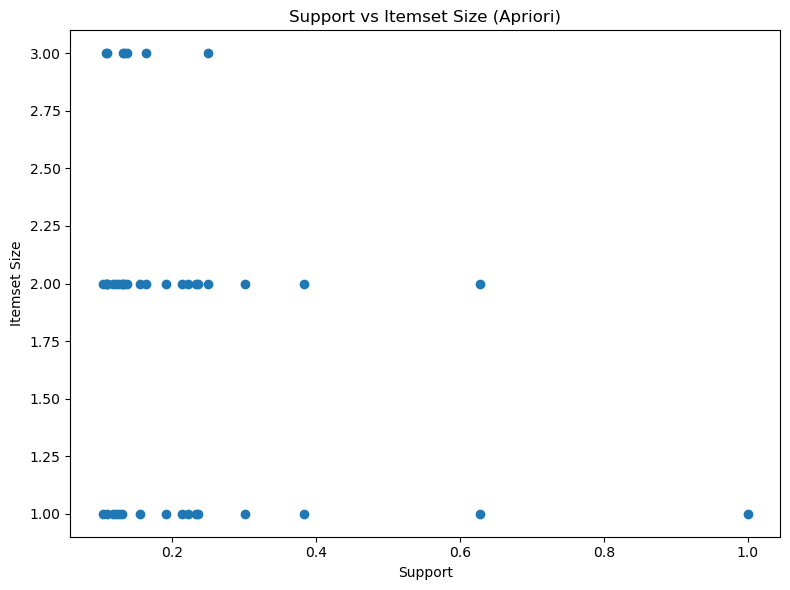

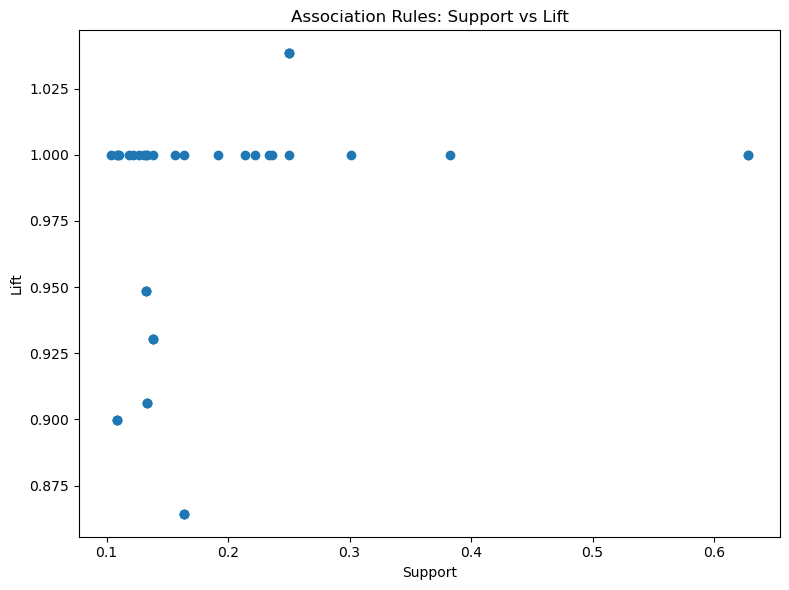

In [14]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth, fpmax, association_rules
import matplotlib.pyplot as plt

columns_for_patterns = [
    'mood_avg', 'circumplex.arousal_avg', 'circumplex.valence_avg',
    'activity_avg', 'screen_num', 'call_sum', 'sms_sum',
    'appCat.builtin_sum', 'appCat.communication_sum', 'appCat.entertainment_sum',
    'appCat.finance_sum', 'appCat.game_sum', 'appCat.office_sum', 'appCat.other_sum',
    'appCat.social_sum', 'appCat.travel_sum', 'appCat.unknown_sum',
    'appCat.utilities_sum', 'appCat.weather_sum',
    'mood_avg_5d', 'circumplex.arousal_avg_5d', 'circumplex.valence_avg_5d',
    'weekday', 'target_mood'
]
raw_transactions = full_df[columns_for_patterns].values.tolist()
encoder = TransactionEncoder()
encoded_array = encoder.fit(raw_transactions).transform(raw_transactions)
binary_df = pd.DataFrame(encoded_array, columns=encoder.columns_)

apriori_sets = apriori(binary_df, min_support=0.1, use_colnames=True)
fpgrowth_sets = fpgrowth(binary_df, min_support=0.1, use_colnames=True)
fpmax_sets = fpmax(binary_df, min_support=0.1, use_colnames=True)

print("=== Apriori Itemsets ===")
print(apriori_sets, "\n")
print("=== FP-Growth Itemsets ===")
print(fpgrowth_sets, "\n")
print("=== FP-Max Itemsets ===")
print(fpmax_sets, "\n")

bottom_n = 5
apr_low = apriori_sets.nsmallest(bottom_n, 'support')
fpg_low = fpgrowth_sets.nsmallest(bottom_n, 'support')
fpmax_low = fpmax_sets.nsmallest(bottom_n, 'support')
print(f"Apriori — {bottom_n} lowest‐support itemsets:\n", apr_low, "\n")
print(f"FP-Growth — {bottom_n} lowest‐support itemsets:\n", fpg_low, "\n")
print(f"FP-Max — {bottom_n} lowest‐support itemsets:\n", fpmax_low)

apriori_sets.to_csv('apriori_itemsets.csv', index=False)
fpgrowth_sets.to_csv('fpgrowth_itemsets.csv', index=False)
fpmax_sets.to_csv('fpmax_itemsets.csv', index=False)

rules = association_rules(apriori_sets, metric='confidence', min_threshold=0.5)
rules = rules.sort_values('lift', ascending=False).reset_index(drop=True)
print("Top 10 association rules by lift:")
print(rules.head(10))
rules.to_csv('association_rules.csv', index=False)

plt.figure(figsize=(8,6))
plt.scatter(apriori_sets['support'], apriori_sets['itemsets'].apply(lambda x: len(x)))
plt.xlabel('Support')
plt.ylabel('Itemset Size')
plt.title('Support vs Itemset Size (Apriori)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(rules['support'], rules['lift'])
plt.xlabel('Support')
plt.ylabel('Lift')
plt.title('Association Rules: Support vs Lift')
plt.tight_layout()
plt.show()


In [15]:

# print("Frequent Itemsets (FP-Growth):\n", frequent_itemsets_fpgrowth)

In [16]:
# print("Frequent Itemsets (FP-max):\n", frequent_itemsets_fpmax)

In [17]:
# apriori_sorted = frequent_itemsets_apriori.sort_values(by='support')
# fpgrowth_sorted = frequent_itemsets_fpgrowth.sort_values(by='support')
# fpmax_sorted = frequent_itemsets_fpmax.sort_values(by='support')

# print("Frequent Itemsets (Apriori - Bottom 5):")
# print(apriori_sorted.head(5))

# print("\nFrequent Itemsets (FP-Growth - Bottom 5):")
# print(fpgrowth_sorted.head(5))

# print("\nFrequent Itemsets (FP- Max - Bottom 5):")
# print(fpmax_sorted.head(5))
